# Julia OpenCL

In this notebook we will look at implementing a diffusion equation in Julia, first in native terms and then using Julia’s OpenCL bindings.

## A note on multi-dimensional arrays

Julia’s multi-dimensional arrays are stored in column-major order (and indexed starting at 1) just like Fortran, whereas array handling in OpenCL are stored in row-major order


row-major, column-major …

\begin{align}
A = \begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \end{bmatrix}
\end{align}

## The heat equation
The first system that we want to investigate is the heat or diffusion equation, it is given by the following differential equation:

\begin{align}
  \frac{\partial}{\partial t}u - \alpha \nabla^2u &= 0
\end{align}


In order for Julia’s JIT optimiser to work properly, every calculation should be wrapped inside a function for maximum speed.

We start with our initial state. For simplicity, we’ll take a rectangular matrix of zeros and fix the centre at a value of 10.

In [1]:
""" Returns the initial state. """
function initial_state(height, width)
    initial = zeros(Float32, height, width)
    # Pick the center
    # Since Julia starts indexing with 1, we use cls to divide and round up
    initial[cld(height, 2), cld(width, 2)] = 10.0
    initial
end    

initial_state

In [2]:
# example
initial_state(5, 5)

5×5 Array{Float32,2}:
 0.0  0.0   0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0
 0.0  0.0  10.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0
 0.0  0.0   0.0  0.0  0.0

In [3]:
function diff_step!(source, diff=similar(source))
    for i in CartesianRange(size(source))
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        neighborsCartesian = map(x -> CartesianIndex{2}(x), neighbors)
        indices = map(neighborsCartesian) do c
            idx = i + c
            CartesianIndex{2}(mod1(idx.I[1], size(source)[1]), mod1(idx.I[2], size(source)[2]))
        end
        diff[i] = - 4 * source[i] + sum(source[indices])
    end
end

diff_step! (generic function with 2 methods)

In [4]:
function add_step!(source, diff, step_size::Float32)
    source .+= step_size * diff
end

add_step! (generic function with 1 method)

In [5]:
function do_native(initial, step_size::Float32, num_steps)
    diff = similar(initial)
    for s in 1:num_steps
        diff_step!(initial, diff)
        add_step!(initial, diff, step_size)
    end
    initial
end

do_native (generic function with 1 method)

In [ ]:
@benchmark add_step(ii, diff, 0.01)

In [ ]:
Pkg.add("BenchmarkTools")

In [ ]:
using BenchmarkTools

In [ ]:
ind1 = CartesianRange(size(ii)) |> first

In [ ]:
neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)] |> y -> map(x -> CartesianIndex{2}((x)), y)

In [ ]:
        neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        neighborsCartesian = map(x -> CartesianIndex{2}(x), neighbors)
        indices = map(neighborsCartesian) do c
            idx = ind1 + c
            CartesianIndex{2}(mod1(idx.I[1], size(ii)[1]), mod1(idx.I[2], size(ii)[2]))
        end

In [ ]:
[i for i in CartesianRange(CartesianIndex{2}((2,1)), CartesianIndex{2}((-5,2)))]

In [ ]:
sum(ii[indices])

In [ ]:
map(x -> CartesianIndex{2}(x), [(-1, 0), (1, 0), (0, -1), (0, 1)])

In [ ]:
ii[ind1 - CartesianIndex{2}((1,1))]

In [ ]:
ii[*(2, 2)]

In [ ]:
m = ones(3, 4, 5)
m[:] = 1:3*4*5
m

In [ ]:
using PyCall

In [ ]:
@pyimport numpy as np

In [ ]:
m = np.reshape(np.array(py"range"(3 * 4 * 5)), (3, 4, 5))

In [ ]:
m[1, 1, 2], m[1, 2, 1], m[2, 1, 1]

In [ ]:
np.array(py"range"(3 * 4 * 5), shape=(3, 4, 5))

In [ ]:
Pkg.add("PyCall")
Pkg.update()

In [ ]:
m[2, 1, 1]

In [ ]:
versioninfo()

In [ ]:
using OpenCL
#using Gadfly

In [ ]:
diff_kernel = "
inline int xy_to_i(int x, int y, int col_size, int mesh_size) {
    return (x % col_size) + (y % col_size) * col_size; 
}

__kernel void diff(__global const float *a,
__global float *diff,
int col_size)
    {
      int gid = get_global_id(0);
      int mesh_size = get_global_size(0);
    int x_idx = gid % col_size;
    int y_idx = gid / col_size;
    
    diff[gid] = - 4. * a[gid]
    + (a[xy_to_i(x_idx - 1, y_idx, col_size, mesh_size)]
    + a[xy_to_i(x_idx + 1, y_idx, col_size, mesh_size)]
    + a[xy_to_i(x_idx, y_idx - 1, col_size, mesh_size)]
    + a[xy_to_i(x_idx, y_idx + 1, col_size, mesh_size)]);
    }
";

In [ ]:
diff_kernel_2d = "
__kernel void diff2d(__global const float *a,
__global float *diff)
    {
      int gidx = get_global_id(0);
      int gidy = get_global_id(1);
      int maxx = get_global_size(0);
      int maxy = get_global_size(1);

   float (*b)[maxy] = (float(*)[maxy]) a;
   float (*d)[maxx] = (float(*)[maxx]) diff;

    d[gidx][gidy] = - 4. * b[gidx][gidy]
    + b[(gidx - 1) % maxx][gidy]
    + b[(gidx + 1) % maxx][gidy]
    + b[gidx][((gidy - 1) % maxy)]
    + b[gidx][((gidy + 1) % maxy)];
    /*
    diff[gidx + gidy * maxx] = - 4. * a[gidx + gidy * maxx]
    + a[(gidx - 1) % maxx + gidy * maxx]
    + a[(gidx + 1) % maxx + gidy * maxx]
    + a[gidx + ((gidy - 1) % maxy) * maxx]
    + a[gidx + ((gidy + 1) % maxy) * maxx];*/
    }
";

In [ ]:
# TODO 2D kernel


In [ ]:
sum_kernel = "
   __kernel void sum(__global float *a,
__global const float *diff,
float step_size)
    {
      int gid = get_global_id(0);
    a[gid] += step_size * diff[gid];
    }
";

In [ ]:
function initial_cond(s=5000, t=s)
    a = zeros(Float32, (s, t))
    a[Int(size(a)[1] / 2) - 2, Int(size(a)[2] / 2) - 2] = 10
    return a
end

In [ ]:
using OpenCL

In [ ]:
function do_openCL(input, step_size, num_steps)
    device, ctx, queue = cl.create_compute_context()
#    print(device, ctx, queue)
#    ctx    = cl.Context(cl.devices()[2])
#    device = cl.devices(ctx)
#    queue  = cl.CmdQueue(ctx)

    input_buff = cl.Buffer(Float32, ctx, (:rw, :copy), hostbuf=input)
    diff_buff = cl.Buffer(Float32, ctx, :rw, length(input))

    diff_p = cl.Program(ctx, source=diff_kernel) |> cl.build!
    diff_k = cl.Kernel(diff_p, "diff")

    sum_p = cl.Program(ctx, source=sum_kernel) |> cl.build!
    sum_k = cl.Kernel(sum_p, "sum")

    for i in 1:num_steps
        queue(diff_k, length(input), nothing, input_buff, diff_buff, size(input)[1])
        queue(sum_k, length(input), nothing, input_buff, diff_buff, Float32(step_size))
    end
    r = cl.read(queue, input_buff);
    r = reshape(r, size(input))
    return r
end



In [ ]:
@benchmark resCL = do_openCL(initial_state(100, 100), 0.001, 1000)

In [ ]:
@benchmark resNative = do_native(initial_state(100, 100), 0.001 :: Float32, 1000)

In [ ]:
do_openCL(initial_state(10, 10), Float32(0.01), 40)

In [ ]:
do_native(initial_state(10, 10), Float32(0.01), 40)

In [ ]:
@benchmark do_openCL(initial_state(100, 100), 0.001, 1000)

In [ ]:
function do_openCL2d(input)
    device, ctx, queue = cl.create_compute_context()
    print(device, ctx, queue)
    input_buff = cl.Buffer(Float32, ctx, (:rw, :copy), hostbuf=input)
    diff_buff = cl.Buffer(Float32, ctx, :rw, length(input))

    diff_p = cl.Program(ctx, source=diff_kernel_2d) |> cl.build!
    diff_k = cl.Kernel(diff_p, "diff2d")

    sum_p = cl.Program(ctx, source=sum_kernel) |> cl.build!
    sum_k = cl.Kernel(sum_p, "sum")

    step_size = 0.001

    for i in 1:2
        queue(diff_k, size(input), nothing, input_buff, diff_buff)
        queue(sum_k, length(input), nothing, input_buff, diff_buff, Float32(step_size))
    end
    r = cl.read(queue, input_buff);
    r = reshape(r, size(input))
    return r
end



In [ ]:
res = do_openCL2d(initial_cond(6, 10))

In [ ]:
maximum(res[:])

In [ ]:
device, ctx, queue = cl.create_compute_context()
methods(queue)

In [ ]:
@time do_openCL(initial_cond(15000))

In [ ]:
cl.devices(cl.create_some_context())

In [ ]:
cl.cl_device_info(3)

In [ ]:
z = initial_cond(20000);

In [ ]:
whos(r"z")

In [ ]:
Pkg.add("GR")

In [ ]:
using GR
GR.inline("mo")
#gr()
#default(show=:inline)
dt, nsteps = 0.03, 30
state = initial_state(5, 5)

for n = 1:nsteps
    state = do_native(state, Float32(0.001), 10)
    GR.contour(1:size(state)[1], 1:size(state)[2], state)
end
GR.show()

In [ ]:
using Plots
Plots.plotlyjs()
x = linspace(0, 2*pi, 100) |> collect 
dt, nsteps = 0.03, 100
for n = 1:nsteps
    IJulia.clear_output(true)
    Plots.plot(x, sin(x - n*dt))  |> display
end

In [6]:
Pkg.add("PyPlot")
using PyPlot

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of PyPlot
INFO: Use `Pkg.update()` to get the latest versions of your packages


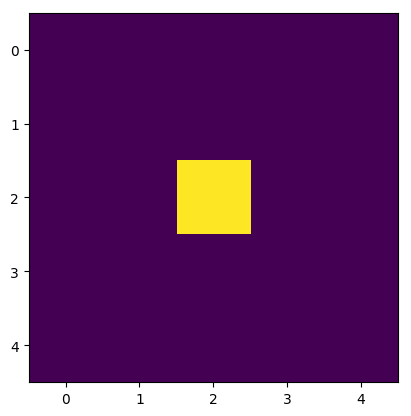

PyObject <matplotlib.image.AxesImage object at 0x32178b2e8>

In [12]:
state = initial_state(5, 5)
PyPlot.imshow(state)

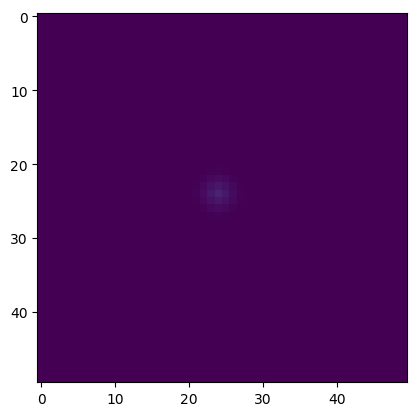

In [27]:
dt, nsteps = 0.03, 100

state = initial_state(50, 50)

#fig = PyPlot.figure()
p = PyPlot.imshow(state)
#anim = Animation()
#inline()


for n = 1:nsteps
    IJulia.clear_output(true)
    state = do_native(state, Float32(0.001), 10)
    p[:set_array](state)
end
#mp4(anim)

In [ ]:
PyPlot.contour(1:size(state)[1], 1:size(state)[2], state, animated=true)

In [ ]:
contour(1:size(state)[1], 1:size(state)[2], state[:])

In [ ]:
Pkg.add("PlotlyJS")

In [ ]:
Pkg.add("Plots")

In [ ]:
cl.devices()

In [ ]:
cl.Context(cl.devices()[3])

In [ ]:
function diff_step(input, output)
    maxX, maxY = size(input)
    @sync @parallel for iter in eachindex(input)
        x, y = ind2sub(input, iter)
        output[iter] = - 4. * input[iter] + input[x, y - 1 == 0 ? maxY : y - 1] + 
        input[x, y + 1 > maxY ? 1 : y + 1] +
        input[x - 1 == 0 ? maxX : x - 1, y] +
        input[x + 1 > maxX ? 1 : x + 1, y]
    end
end

In [ ]:
function sum_step(input, diff, step_size)
    @sync @parallel for iter in eachindex(input)
        input[iter] += (step_size * diff[iter])
    end
end
    

In [ ]:
function do_naive(input)
    step_size = 0.001

    diff = similar(input)
    for i in 1:10
        diff_step(input, diff)
        sum_step(input, diff, step_size)
    end
    return input
end

In [ ]:
addprocs()

In [ ]:
@time res = do_naive(initial_cond(500, 5000));

In [ ]:
maximum(res)

In [ ]:
a = [1, 3, 5]
c = [2, 3, 5]
b = similar(a)
@time b += a * 5

In [ ]:
cl.devices()

In [ ]:
Pkg.add('PyPlot')

In [ ]:
initial_cond()[1,2]

In [ ]:
stencil = [0 1 0; 1 -4 1; 0 1 0]